In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ==== Cell W1: Install/verify ipywidgets for JupyterLab and smoke test ====
import sys, subprocess, importlib, os, time
from importlib.metadata import version, PackageNotFoundError

def ensure(pkg, ver=None):
    try:
        v = version(pkg)
        if ver and v != ver:
            print(f"[{pkg}] found {v} but prefer {ver} -> upgrading...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}=={ver}"])
            v = version(pkg)
        else:
            print(f"[{pkg}] OK {v}")
        return True
    except PackageNotFoundError:
        to_install = f"{pkg}=={ver}" if ver else pkg
        print(f"[{pkg}] installing {to_install} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", to_install])
        print(f"[{pkg}] OK {version(pkg)}")
        return True

# Versions that work well with JupyterLab 4.x
ensure("ipywidgets", "8.1.5")
ensure("jupyterlab_widgets", "3.0.11")

# Smoke test: show a slider + live label, and a progress bar that fills.
from IPython.display import display
import ipywidgets as widgets

print("\nIf widgets render correctly, you should see a slider, a label that updates, and a progress bar filling to 100%.\n")

slider = widgets.IntSlider(value=5, min=0, max=10, description="Slider:")
label  = widgets.Label(value=f"Value = {slider.value}")
widgets.jslink((slider, "value"), (label, "value"))  # label.text becomes an int; show with a trait

# For nicer label text, use observe:
def on_change(change):
    if change["name"] == "value":
        label.value = f"Value = {change['new']}"
slider.observe(on_change, names="value")

bar = widgets.IntProgress(value=0, min=0, max=100, description="Loading:", bar_style="")
box = widgets.VBox([slider, label, bar])
display(box)

# Fill progress slowly so you can see it animate
for i in range(0, 101, 5):
    bar.value = i
    time.sleep(0.03)

print("\nwidgets status: OK (if you saw the UI above).")

[ipywidgets] OK 8.1.5
[jupyterlab_widgets] OK 3.0.11

If widgets render correctly, you should see a slider, a label that updates, and a progress bar filling to 100%.




widgets status: OK (if you saw the UI above).


In [3]:
# ==== Cell W2: Simple ipywidgets UI for Stable Diffusion (CPU) ====
import os, time, math, random, textwrap, re
from pathlib import Path
from datetime import datetime
import torch
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets

from diffusers import StableDiffusionPipeline, DDIMScheduler, DPMSolverMultistepScheduler

# ---------- paths & env ----------
PROJECT = Path("/scratch/qin.yife/Generative_Project")
HF_HOME = os.environ.get("HF_HOME", str(PROJECT / ".cache" / "huggingface"))
OUT_DIR = PROJECT / "app" / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"] = HF_HOME
# Avoid requiring hf_transfer
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

device = torch.device("cpu")

# ---------- model loading (lazy) ----------
_pipe = None
_curr_sched = None
MODEL_ID = "runwayml/stable-diffusion-v1-5"

def get_pipe(scheduler_name: str, safety_off: bool):
    global _pipe, _curr_sched
    if _pipe is None:
        # initial load
        kwargs = dict(torch_dtype=torch.float32)
        if safety_off:
            kwargs["safety_checker"] = None
        _pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, **kwargs).to(device)
        _pipe.set_progress_bar_config(disable=True)
        _curr_sched = "DPMSolver"  # will be overridden by set_scheduler() below

    # flip safety checker on/off if needed
    if safety_off and _pipe.safety_checker is not None:
        _pipe.safety_checker = None
    elif (not safety_off) and _pipe.safety_checker is None:
        # re-create a safe pipeline head if user toggles it back on
        _pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float32).to(device)
        _pipe.set_progress_bar_config(disable=True)

    set_scheduler(scheduler_name)
    return _pipe

def set_scheduler(name: str):
    global _pipe, _curr_sched
    if _pipe is None: 
        return
    if name == _curr_sched:
        return
    if name == "DPMSolver":
        _pipe.scheduler = DPMSolverMultistepScheduler.from_config(_pipe.scheduler.config)
    elif name == "DDIM":
        _pipe.scheduler = DDIMScheduler.from_config(_pipe.scheduler.config)
    else:
        raise ValueError(f"Unknown scheduler: {name}")
    _curr_sched = name

# ---------- utils ----------
def slug(s: str, n=40):
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "-", s).strip("-")
    return s[:n] if n else s

def gen_filename(prefix: str, prompt: str, scheduler: str, steps: int, cfg: float, seed: int, w: int, h: int):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{prefix}_{scheduler}_cfg{cfg}_s{steps}_seed{seed}_{w}x{h}_{slug(prompt,25)}_{ts}.png"

# ---------- widgets ----------
prompt = widgets.Textarea(
    value="A photo of a golden retriever playing in a park",
    description="Prompt:",
    layout=widgets.Layout(width="100%", height="80px"),
)

negative = widgets.Text(
    value="blurry, low quality, lowres, bad anatomy, deformed, distorted, extra limbs, extra fingers",
    description="Negative:",
    layout=widgets.Layout(width="100%")
)

scheduler = widgets.Dropdown(
    options=["DPMSolver", "DDIM"],
    value="DPMSolver",
    description="Scheduler:",
    layout=widgets.Layout(width="220px")
)

steps = widgets.IntSlider(
    value=20, min=10, max=50, step=2,
    description="Steps:", continuous_update=False,
    layout=widgets.Layout(width="350px")
)

cfg = widgets.FloatSlider(
    value=7.5, min=1.0, max=12.0, step=0.5,
    description="Guidance:", continuous_update=False,
    layout=widgets.Layout(width="350px")
)

rescale = widgets.FloatSlider(
    value=0.7, min=0.0, max=1.0, step=0.05,
    description="Rescale:", continuous_update=False,
    layout=widgets.Layout(width="350px")
)

width = widgets.Dropdown(options=[384, 448, 512], value=384, description="Width:")
height = widgets.Dropdown(options=[384, 448, 512], value=384, description="Height:")

seed = widgets.IntText(value=123, description="Seed:")
rand_seed = widgets.Checkbox(value=False, description="Randomize seed")

safety_off = widgets.Checkbox(value=True, description="Disable safety checker")
save_img = widgets.Checkbox(value=True, description="Save image")
out_dir_text = widgets.Text(value=str(OUT_DIR), description="Save to:")

run_btn = widgets.Button(description="Generate", button_style="primary")
status = widgets.Label(value="Ready.")
prog = widgets.IntProgress(value=0, min=0, max=100, description="Progress:")

img_out = widgets.Output()
meta_out = widgets.Output()

# Layout
row1 = widgets.VBox([prompt, negative])
row2 = widgets.HBox([scheduler, steps, cfg])
row3 = widgets.HBox([rescale, width, height])
row4 = widgets.HBox([seed, rand_seed, safety_off])
row5 = widgets.HBox([save_img, out_dir_text])
ctrls = widgets.VBox([row1, row2, row3, row4, row5, widgets.HBox([run_btn, status]), prog])

ui = widgets.VBox([ctrls, img_out, meta_out])
display(ui)

# ---------- runner ----------
@torch.inference_mode()
def do_generate(_prompt, _neg, _sched, _steps, _cfg, _rescale, _seed, _w, _h, _save, _safety_off):
    global _pipe
    prog.value = 5
    status.value = "Loading pipeline..."
    t0 = time.time()
    pipe = get_pipe(_sched, _safety_off)

    if rand_seed.value:
        _seed = random.randint(1, 10_000_000)
        seed.value = _seed

    generator = torch.Generator(device=device).manual_seed(int(_seed))
    prog.value = 15
    status.value = "Encoding prompt..."

    # Generate
    t1 = time.time()
    image = pipe(
        prompt=_prompt,
        negative_prompt=_neg,
        num_inference_steps=int(_steps),
        guidance_scale=float(_cfg),
        guidance_rescale=float(_rescale),
        generator=generator,
        width=int(_w),
        height=int(_h),
    ).images[0]
    t2 = time.time()
    prog.value = 95

    # Save if requested
    saved_path = None
    if _save:
        out_dir = Path(out_dir_text.value).expanduser()
        out_dir.mkdir(parents=True, exist_ok=True)
        fname = gen_filename("ui", _prompt, _sched, _steps, _cfg, _seed, _w, _h)
        saved_path = out_dir / fname
        image.save(saved_path)

    # Show image & meta
    with img_out:
        clear_output(wait=True)
        display(image)

    meta = {
        "model_id": MODEL_ID,
        "scheduler": _sched,
        "device": str(device),
        "steps": _steps,
        "guidance_scale": _cfg,
        "guidance_rescale": _rescale,
        "seed": _seed,
        "size": f"{_w}x{_h}",
        "load_time_sec": round(t1 - t0, 2),
        "gen_time_sec": round(t2 - t1, 2),
        "saved_to": str(saved_path) if saved_path else None,
    }
    with meta_out:
        clear_output(wait=True)
        print(meta)

    prog.value = 100
    status.value = "Done."

def on_click(_):
    try:
        prog.value = 0
        status.value = "Starting..."
        do_generate(
            prompt.value, negative.value,
            scheduler.value, steps.value, cfg.value, rescale.value,
            seed.value, width.value, height.value,
            save_img.value, safety_off.value
        )
    except Exception as e:
        status.value = f"Error: {e}"

run_btn.on_click(on_click)

2025-12-05 11:14:33.982589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# ==== Cell W3: Parameter-sweep grid (steps × guidance) for one prompt ====
import os, time, math, random, re
from pathlib import Path
from datetime import datetime

import torch
from PIL import Image, ImageDraw, ImageFont
import ipywidgets as widgets
from IPython.display import display, clear_output

# We assume W2 ran and defined: get_pipe(), set_scheduler(), MODEL_ID, device, OUT_DIR.
# If not, you can re-run W2 first.

# ---------- small utils ----------
def slug(s: str, n=40):
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "-", s).strip("-")
    return s[:n] if n else s

def timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def make_grid(images, rows, cols, pad=6, bg=(245,245,245)):
    assert len(images) == rows * cols
    w, h = images[0].size
    W = cols * w + (cols + 1) * pad
    H = rows * h + (rows + 1) * pad
    canvas = Image.new("RGB", (W, H), bg)
    k = 0
    for r in range(rows):
        for c in range(cols):
            x = pad + c * (w + pad)
            y = pad + r * (h + pad)
            canvas.paste(images[k], (x, y))
            k += 1
    return canvas

def latents_for(pipe, width, height, seed):
    # Create fixed initial noise so comparisons are fair across params
    g = torch.Generator(device=device).manual_seed(int(seed))
    ch = pipe.unet.config.in_channels
    h = height // 8
    w = width // 8
    return torch.randn((1, ch, h, w), generator=g, device=device, dtype=torch.float32)

# ---------- widgets ----------
prompt_w = widgets.Textarea(
    value="Two gray dogs run near the water on a manicured lawn in the fall.",
    description="Prompt:",
    layout=widgets.Layout(width="100%", height="70px"),
)

negative_w = widgets.Text(
    value="blurry, low quality, lowres, bad anatomy, deformed, distorted, extra limbs, extra fingers",
    description="Negative:",
    layout=widgets.Layout(width="100%"),
)

scheduler_w = widgets.Dropdown(
    options=["DPMSolver", "DDIM"],
    value="DPMSolver",
    description="Scheduler:",
    layout=widgets.Layout(width="220px"),
)

# Choose a small set by default for CPU
steps_w = widgets.SelectMultiple(
    options=[16, 20, 24, 28, 32, 36],
    value=(20, 28),
    description="Steps:",
    layout=widgets.Layout(width="220px", height="120px"),
)

cfg_w = widgets.SelectMultiple(
    options=[3.0, 5.0, 7.5, 10.0],
    value=(5.0, 7.5, 10.0),
    description="Guidance:",
    layout=widgets.Layout(width="220px", height="120px"),
)

rescale_w = widgets.FloatSlider(
    value=0.7, min=0.0, max=1.0, step=0.05,
    description="Rescale:", continuous_update=False,
    layout=widgets.Layout(width="350px"),
)

width_w  = widgets.Dropdown(options=[384, 448, 512], value=384, description="Width:")
height_w = widgets.Dropdown(options=[384, 448, 512], value=384, description="Height:")

seed_w = widgets.IntText(value=20251114, description="Seed:")
save_w = widgets.Checkbox(value=True, description="Save grid")
outdir_w = widgets.Text(value=str(OUT_DIR), description="Save to:")

run_btn = widgets.Button(description="Generate Grid", button_style="primary")
status_w = widgets.Label(value="Ready.")
prog_w = widgets.IntProgress(value=0, min=0, max=100, description="Progress:")

img_out = widgets.Output()
meta_out = widgets.Output()
table_out = widgets.Output()

# Layout
row1 = widgets.VBox([prompt_w, negative_w])
row2 = widgets.HBox([scheduler_w, steps_w, cfg_w])
row3 = widgets.HBox([rescale_w, width_w, height_w])
row4 = widgets.HBox([seed_w, save_w, outdir_w])
controls = widgets.VBox([row1, row2, row3, row4, widgets.HBox([run_btn, status_w]), prog_w])

ui = widgets.VBox([controls, img_out, table_out, meta_out])
display(ui)

@torch.inference_mode()
def generate_grid():
    status_w.value = "Loading pipeline..."
    prog_w.value = 5

    pipe = get_pipe(scheduler_w.value, safety_off=True)  # same as W2 default
    set_scheduler(scheduler_w.value)

    steps_list = list(steps_w.value)
    cfg_list   = list(cfg_w.value)
    steps_list.sort()
    cfg_list.sort()

    rows, cols = len(steps_list), len(cfg_list)
    total = rows * cols
    if total == 0:
        raise ValueError("Please select at least one Steps and one Guidance value.")

    W, H = int(width_w.value), int(height_w.value)
    base_latents = latents_for(pipe, W, H, seed_w.value)

    images = []
    k = 0
    t0 = time.time()
    for r, s in enumerate(steps_list):
        for c, cfg in enumerate(cfg_list):
            k += 1
            status_w.value = f"Rendering {k}/{total} ... (steps={s}, cfg={cfg})"
            prog_w.value = int(5 + 90 * (k / total))

            img = pipe(
                prompt=prompt_w.value.strip(),
                negative_prompt=negative_w.value.strip(),
                num_inference_steps=int(s),
                guidance_scale=float(cfg),
                guidance_rescale=float(rescale_w.value),
                width=W,
                height=H,
                latents=base_latents.clone(),  # fixed noise per cell
            ).images[0]
            images.append(img)

    grid = make_grid(images, rows, cols)
    t1 = time.time()

    # Save grid (optional)
    saved_path = None
    if save_w.value:
        out_dir = Path(outdir_w.value).expanduser()
        out_dir.mkdir(parents=True, exist_ok=True)
        fname = f"grid_{scheduler_w.value}_seed{seed_w.value}_{W}x{H}_{rows}x{cols}_{slug(prompt_w.value,25)}_{timestamp()}.png"
        saved_path = out_dir / fname
        grid.save(saved_path)

    # Show outputs
    with img_out:
        clear_output(wait=True)
        display(grid)

    # Simple text table mapping row/col to params
    with table_out:
        clear_output(wait=True)
        print("Grid map (rows = Steps, cols = Guidance):")
        header = "       " + " | ".join([f"cfg={v}" for v in cfg_list])
        print(header)
        print("-" * len(header))
        for i, s in enumerate(steps_list):
            row = [f"steps={s}"]
            row += [f"[{i},{j}]" for j in range(cols)]
            print("  ".join(row))

    meta = {
        "model_id": MODEL_ID,
        "scheduler": scheduler_w.value,
        "device": str(device),
        "size": f"{W}x{H}",
        "seed": int(seed_w.value),
        "rescale": float(rescale_w.value),
        "steps_list": steps_list,
        "guidance_list": cfg_list,
        "cells": rows * cols,
        "gen_time_sec": round(t1 - t0, 2),
        "saved_to": str(saved_path) if saved_path else None,
    }
    with meta_out:
        clear_output(wait=True)
        print(meta)

    status_w.value = "Done."
    prog_w.value = 100

def on_click(_):
    try:
        prog_w.value = 0
        status_w.value = "Starting..."
        generate_grid()
    except Exception as e:
        status_w.value = f"Error: {e}"

run_btn.on_click(on_click)

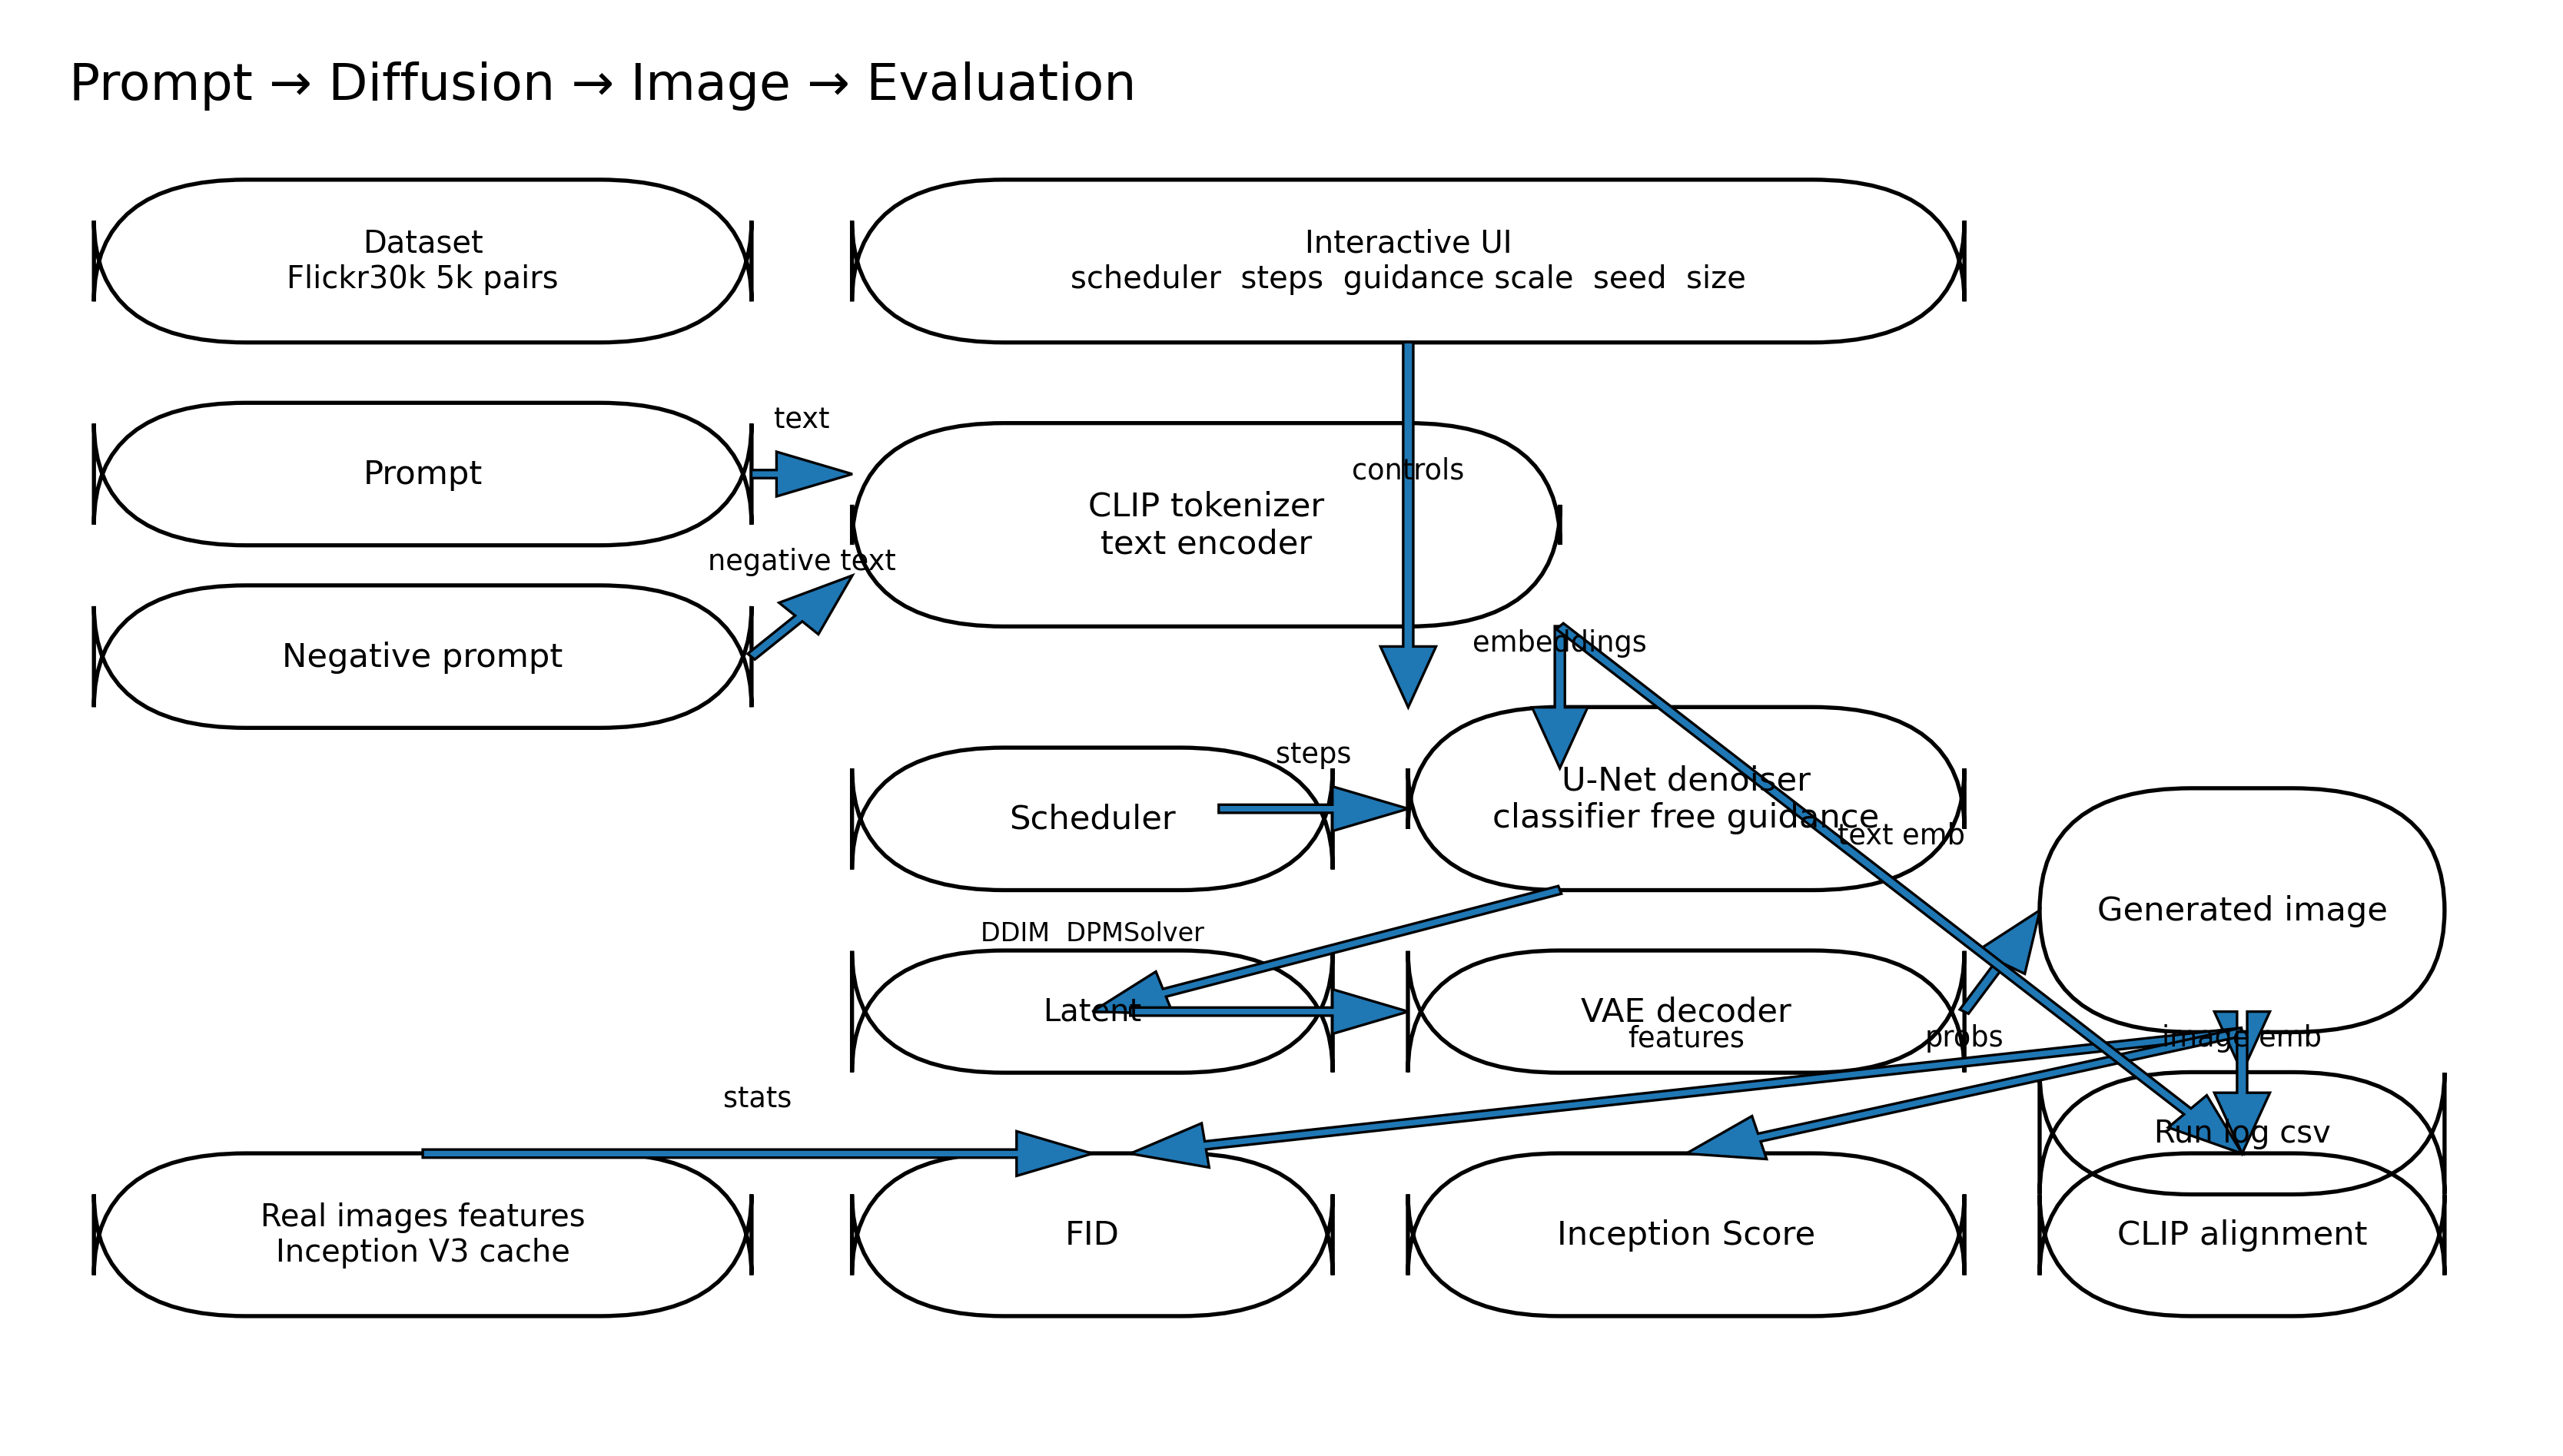

Saved:
 - /scratch/qin.yife/Generative_Project/outputs/pipeline_poster.png
 - /scratch/qin.yife/Generative_Project/outputs/pipeline_poster.pdf


In [5]:
# Poster-style figure: Prompt → Diffusion → Image → Evaluation
# Requirements: matplotlib only

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrow
from pathlib import Path

# Save paths
png_path = Path("/scratch/qin.yife/Generative_Project/outputs/pipeline_poster.png")
pdf_path = Path("/scratch/qin.yife/Generative_Project/outputs/pipeline_poster.pdf")
png_path.parent.mkdir(parents=True, exist_ok=True)

# Use non-interactive backend to be robust in JupyterLab
matplotlib.use("agg")

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 100)
ax.set_ylim(0, 70)
ax.axis("off")

def rbox(x, y, w, h, text, fs=12, lw=1.6):
    patch = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.0125,rounding_size=6",
                           linewidth=lw, fill=False)
    ax.add_patch(patch)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=fs)
    return patch

def arrow(x0, y0, x1, y1, txt=None, fs=11):
    arr = FancyArrow(x0, y0, x1-x0, y1-y0, width=0.4,
                     head_width=2.2, head_length=3.0, length_includes_head=True)
    ax.add_patch(arr)
    if txt:
        ax.text((x0+x1)/2, (y0+y1)/2 + 2.0, txt, ha="center", va="bottom", fontsize=fs)

# Title
ax.text(2, 66, "Prompt → Diffusion → Image → Evaluation", fontsize=20, ha="left")

# Data and prompts
rbox(3, 54, 26, 8,  "Dataset\nFlickr30k 5k pairs", fs=12)
rbox(3, 44, 26, 7,  "Prompt", fs=13)
rbox(3, 35, 26, 7,  "Negative prompt", fs=13)
rbox(33, 40, 28, 10, "CLIP tokenizer\ntext encoder", fs=13)
arrow(29, 47.5, 33, 47.5, "text", fs=11)
arrow(29, 38.5, 33, 42.5, "negative text", fs=11)

# Diffusion pipeline
rbox(33, 27, 19, 7,  "Scheduler", fs=13)
ax.text(42.5, 25.5, "DDIM  DPMSolver", ha="center", va="top", fontsize=10)
rbox(55, 27, 22, 9,  "U-Net denoiser\nclassifier free guidance", fs=13)
rbox(33, 18, 19, 6,  "Latent", fs=12)
rbox(55, 18, 22, 6,  "VAE decoder", fs=13)
arrow(47.5, 31, 55, 31, "steps", fs=11)
arrow(61, 40, 61, 33, "embeddings", fs=11)
arrow(61, 27, 42.5, 21)     # U-Net → latent
arrow(44, 21, 55, 21)       # latent → VAE

# Output and log
rbox(80, 20, 16, 12, "Generated image", fs=13)
rbox(80, 12, 16, 6,  "Run log csv", fs=12)
arrow(77, 21, 80, 26)       # VAE → image
arrow(88, 20, 88, 18)       # image → log

# UI controls
rbox(33, 54, 44, 8, "Interactive UI\nscheduler  steps  guidance scale  seed  size", fs=12)
arrow(55, 54, 55, 36, "controls", fs=11)

# Evaluation
rbox(3, 6,  26, 8,  "Real images features\nInception V3 cache", fs=12)
rbox(33, 6, 19, 8,  "FID", fs=13)
rbox(55, 6, 22, 8,  "Inception Score", fs=13)
rbox(80, 6, 16, 8,  "CLIP alignment", fs=13)

arrow(16, 14, 42.5, 14, "stats", fs=11)    # real → FID
arrow(88, 20, 44, 14, "features", fs=11)   # image → FID
arrow(88, 20, 66, 14, "probs", fs=11)      # image → IS
arrow(88, 20, 88, 14, "image emb", fs=11)  # image → CLIP
arrow(61, 40, 88, 14, "text emb", fs=11)   # text → CLIP

fig.tight_layout()
fig.savefig(png_path, dpi=240, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")

# Try to show inline if possible
try:
    from IPython.display import Image, display
    display(Image(filename=str(png_path)))
except Exception as e:
    print("Inline display skipped:", e)

print("Saved:")
print(" -", png_path)
print(" -", pdf_path)